### Import and Configuration:

In [193]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.decomposition import PCA
from IPython.core.display import display, HTML

import seaborn as sns
from sklearn.cluster import KMeans
from IPython.html.widgets import interact

display(HTML("""
<style>
.output_png{
    display: table-cell;
    text-align: left;
    vertical-align: middle;
}
.container{width:90% !important;}
</style>"""))

random.seed(149)

In [194]:
def loaddata():
    return pd.read_csv('food_coded.csv')
data = loaddata()

## Preprocessing:

#### Employment:

For this column we will count the probability distribution then we will fill the NAs by sampling from it.

In [295]:
probibility = data['employment'].value_counts() / data['employment'].value_counts().sum().tolist()
count_of_nas = pd.isna(data['employment']).sum()
values = probibility.cumsum().searchsorted(np.random.uniform(size=count_of_nas))
for i in xrange(len(values)):
    if values[i] == 0: values[i] = 2
    elif values[i] == 1: values[i] = 3
    else: values[i] = 1
index = 0
for i in xrange(len(data.employment)):
    if pd.isnull(data.iloc[i].employment):
        data.loc[i, 'employment'] = values[index]
        index += 1

#### Sports:

We took a look on the students' answers and compiled a list of their sports, then replaced their text answers with a comma seperated list of the sports they played. Morever, we replaced any other answers like "I don't play sports" and "not really" with a 'None'

In [196]:
sports = ['car racing', 'basketball', 'softball', 'soccer', 'field hockey', 'running', 'volleyball', 'hockey', \
          'dancing', 'tennis', 'gym', 'football', 'lacrosse', 'snowboarding', 'wrestling', 'rowing', 'skiing', \
          'water polo', 'baseball', 'horse back riding', 'golf']
sports.sort(key=len, reverse=True)

def func(x):
    output = ''
    for sport in sports:
        if pd.isnull(x): continue
        x = x.lower()
        if x.find(sport) != -1:
            output += sport + ','
            x.replace(sport, '')
    if len(output) == 0: return 'None'
    return output[:-1]
data.type_sports = data.type_sports.apply(func=func)

#### Weight:

For this feature we filled the NAs by setting them to the mean of the column.

In [198]:
weight_mean = np.nanmean(data['weight'])
data.weight = data.weight.fillna(weight_mean)

#### Reamining Features:

Most of the remaining features are categorical responses, so using the mean here is not applicable becaus we will introduce values that are not part of the categories. Therefore, we chose the mode as our filling method.

In [ ]:
for col in data.columns:
    data.loc[:,col] = data[col].fillna(data[col].mode()[0])

## Plots:
### First: descriptive statistics:

Here we'll define some plotting functions to plot single features e.g. 'Weight', 'Gender', 'Current Diet'....

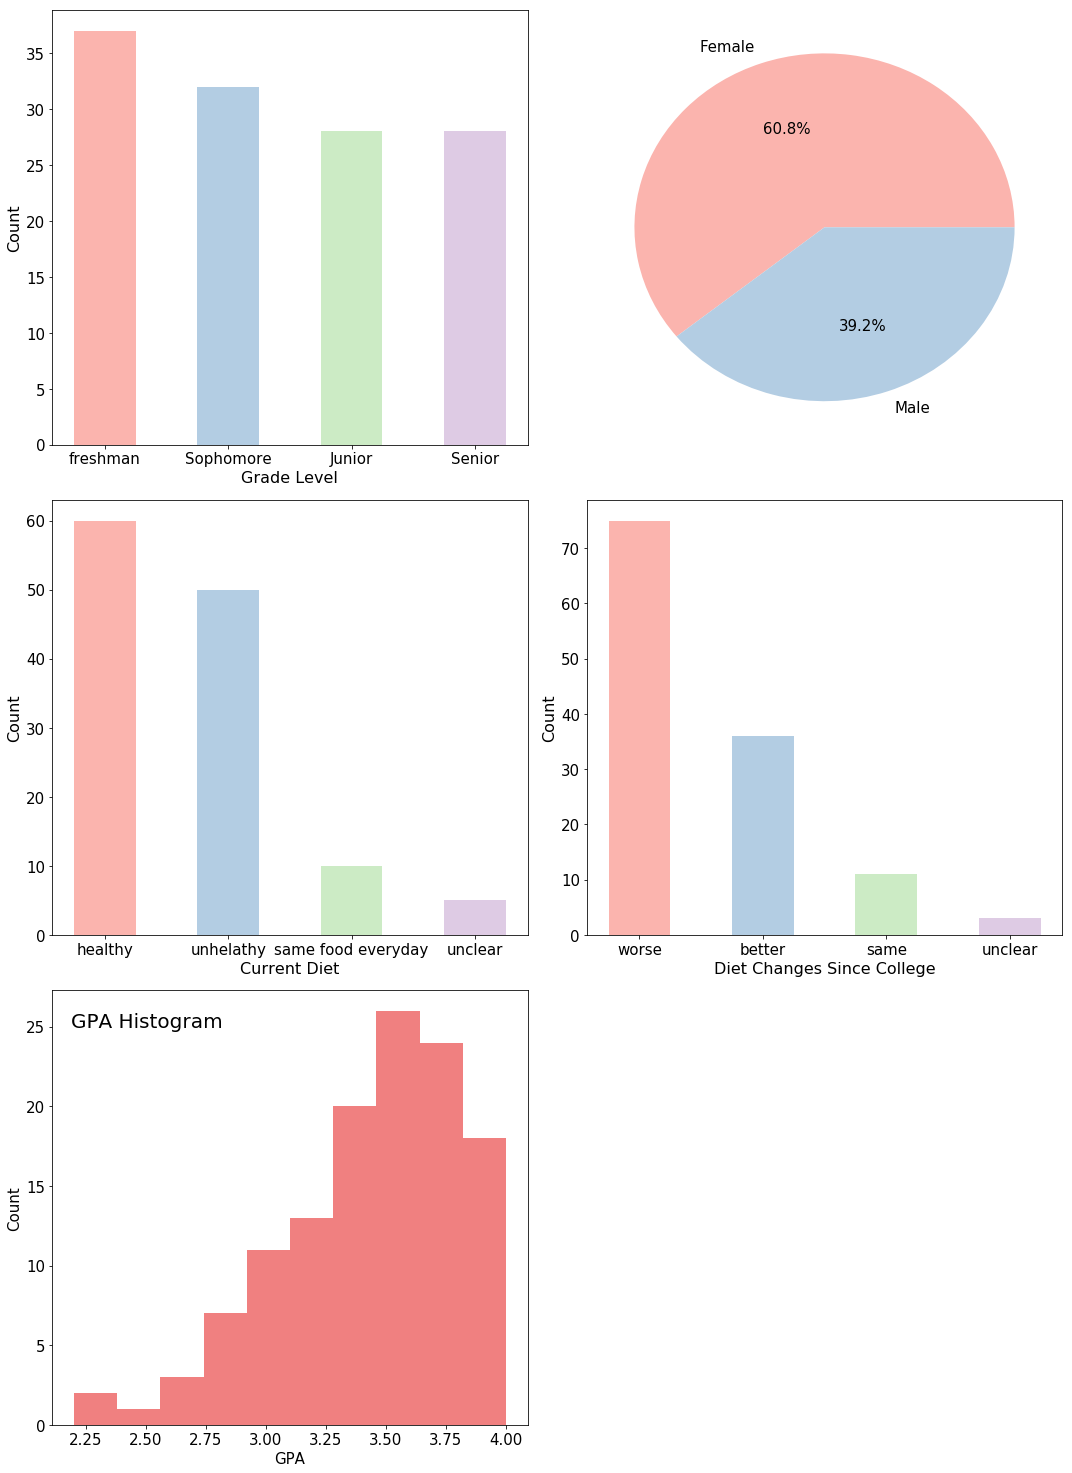

In [290]:
def bar_chart(attribute, ticks_values,label, position):
    plt.subplot(position)
    y = data[attribute].value_counts()
    N = len(y)
    x = range(N)
    width = 0.5

    plt.bar(x, y, width, color=sns.color_palette("Pastel1"))
    plt.xlabel(label, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.tick_params(axis='both',which='major', labelsize=15)
    index = ind = np.arange(len(x)) 
    plt.xticks(index, ticks_values)
    plt.tight_layout()

def piechart(position):
    labels = ['Female', 'Male']
    sizes = [sum(data.Gender == 1), sum(data.Gender == 2)]
    explode = [0,0]
    plt.subplot(position)
    patches, texts, autotexts = plt.pie(sizes, labels=labels,colors = sns.color_palette("Pastel1"), autopct = '%1.1f%%')
    plt.tick_params(axis='both',which='major', labelsize=15)
    texts[0].set_fontsize(15)
    texts[1].set_fontsize(15)
    autotexts[0].set_fontsize(15)
    autotexts[1].set_fontsize(15)


plt.rcParams['figure.figsize'] = (15,20)
bar_chart('grade_level',('freshman' ,'Sophomore' ,'Junior' ,'Senior'),'Grade Level', 321)
piechart(322)
bar_chart('diet_current_coded',('healthy' ,'unhelathy' ,'same food everyday' ,'unclear'),'Current Diet', 323)
bar_chart('eating_changes_coded',('worse' ,'better' ,'same' ,'unclear'),'Diet Changes Since College', 324)

plt.subplot(325)
plt.hist(data.GPA, color='lightcoral')
plt.title("GPA Histogram", fontsize=20, position=(0.2, 0.9))
plt.ylabel("Count", fontsize=15)
plt.xlabel("GPA", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

----

Our data contained features with open ended responses as text. A wordcloud can be a good option to visualize such features.


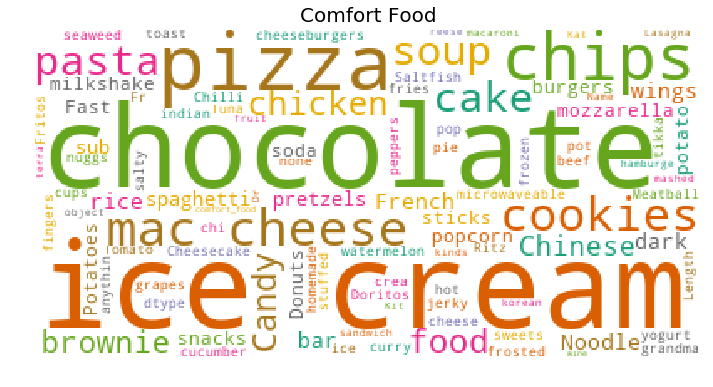

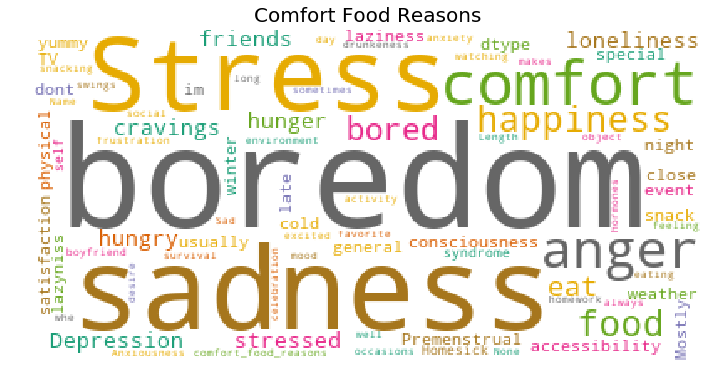

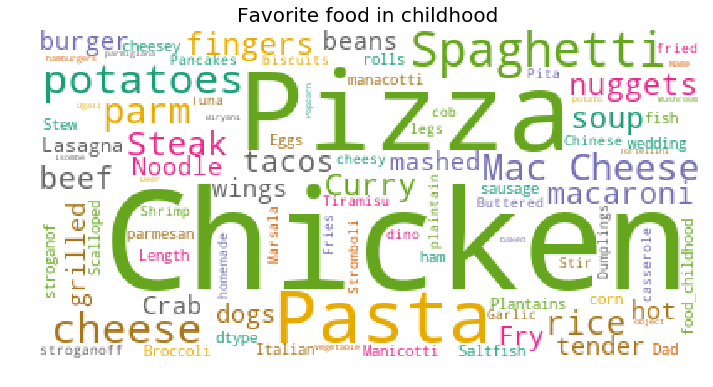

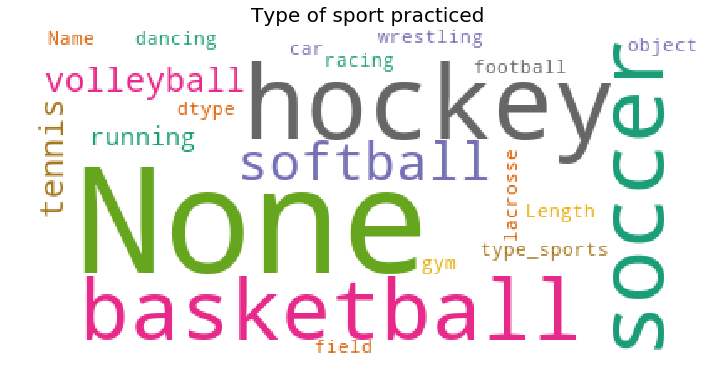

In [294]:
def word_cloud(attribute,title):
    wordcloud = WordCloud(background_color='white',colormap='Dark2').generate(str(data[attribute]))
    plt.rcParams['figure.figsize'] = (12,10)
    plt.imshow(wordcloud)
    plt.title(title, fontsize=20)
    plt.box(on=True)
    plt.axis('off')
    plt.show()
word_cloud('comfort_food','Comfort Food')
word_cloud('comfort_food_reasons', 'Comfort Food Reasons')
word_cloud('food_childhood', 'Favorite food in childhood')
word_cloud('type_sports', 'Type of sport practiced')

### Second: relation between attributes:

Defining some plotting funcitons for re-usability  when plotting different features against eachother.

In [395]:
def boxplot(attribute):
    plt.figure(dpi=100, figsize=(10,10))
    plt.rc('axes', axisbelow=True)
    plt.boxplot([list(data.query('Gender==1')[attribute].dropna()), list(data.query('Gender==2')[attribute].dropna())], labels=["Female", "Male"])
    plt.rc('axes', axisbelow=True)
    plt.xlabel(str.capitalize(attribute), fontsize=20)
    plt.title(str.capitalize(attribute) + ' Boxplot')
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.grid(True)
    y_ticks = np.arange(data[attribute].min(), data[attribute].max(), 15)
    plt.yticks(y_ticks)
    plt.show()

def bubble_chart(x_attribute, x_ticks, y_attribute, y_ticks, size, y_label=''):
    plt.clf()
    plt.rcParams['figure.figsize'] = (25,15)
    fig, ax = plt.subplots()
    
    x_axis = data[x_attribute].round(decimals=1).dropna().unique()
    for mark in x_axis:
        y_axis =  data.query('%s == %f' % (x_attribute, mark))[y_attribute].dropna().unique()
        y_axis.sort()
        s = [(size * 20 * len(data.query('%s == %f & %s == %f' % (x_attribute, mark, y_attribute, i) ))) ** 2 for i in y_axis]
        x = [mark]*len(y_axis)
        plt.scatter(x, y_axis, s = s, color="#00ace6", alpha=0.6,edgecolors="black", linewidth=2)

    if len(y_ticks) == 0:
        y_ticks = data[y_attribute].round(decimals=1).dropna().unique()
    plt.yticks(range(len(y_ticks)), y_ticks)

    plt.tick_params
    if len(x_ticks) != 0:
        ax.set_xticklabels(x_ticks)
    plt.ylabel(y_label, fontsize= 15)
    plt.xlabel(str.capitalize(x_attribute), fontsize= 15)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.margins(0.1)
    plt.show()
    
def grouped_barchart(x_attribute, x_labels, y_attribute, legend, legend_title, plot_title='', x_label=''):
    plt.clf()
    plt.rcParams['figure.figsize'] = (25,10)
    fig, ax = plt.subplots()

    x_axis_unique = data[x_attribute].round(decimals=1).dropna().unique()
    x_axis_unique.sort()

    y_axis_unique = data[y_attribute].round(decimals=1).dropna().unique()
    y_axis_unique.sort()

    ind = np.arange(len(x_axis_unique))    # the x locations for the groups
    width = 0.15                           # the width of the bars
    likert_colors = sns.color_palette("Pastel1")
    for i in xrange(len(y_axis_unique)):
        y = y_axis_unique[i]
        counts = []
        for x in x_axis_unique:
            counts += [len(data.query('%s == %f & %s == %f' % (x_attribute, x, y_attribute, y)))]
        plt.bar(ind + i*width, counts, width, bottom=0, color=likert_colors[i])
    
    if plot_title == '': plot_title = ('%s vs %s' % (x_attribute.replace('_', ' '), y_attribute.replace('_', ' ')))
    ax.set_title(plot_title,  fontsize=20)
    ax.set_xticks(ind + 4*width / 2)
    ax.set_xticklabels(x_labels)
    
    if x_label == '': x_label = x_attribute
    plt.xlabel(x_label, fontsize=20)
    plt.ylabel('Count', fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt_legend = plt.legend(legend, title=legend_title, fontsize=15)
    plt_legend.get_title().set_fontsize('15')
    plt.show()
    
def horizontal_barchart(y_attribute, y_ticks, x_attribute, legend=[], legend_title='', plot_title='', y_label=''):
    plt.clf()
    plt.rcParams['figure.figsize'] = (25,13)

    x_axis_unique = data[x_attribute].round(decimals=1).dropna().unique()
    x_axis_unique.sort()

    y_axis_unique = data[y_attribute].round(decimals=1).dropna().unique()
    y_axis_unique.sort()

    ind = np.arange(len(x_axis_unique))    # the x locations for the groups
    likert_colors = sns.color_palette('Pastel1')
    all_counts1 = []
    all_counts2 = []
    for i in xrange(len(y_axis_unique)):
        y = y_axis_unique[i]
        counts1 = []
        counts2 = []
        counts1 += [len(data.query('%s == %f & %s == %f & Gender == 1' % (x_attribute, x, y_attribute, y))) for x in x_axis_unique]
        counts2 += [-len(data.query('%s == %f & %s == %f & Gender == 2' % (x_attribute, x, y_attribute, y))) for x in x_axis_unique]
        all_counts1 += [counts1]
        all_counts2 += [counts2]

    xvalues = range(-15, 20, 5)
    male_data = pd.DataFrame(all_counts1,
                    columns=x_axis_unique,
                    index=y_axis_unique)
    ax = male_data.plot.barh(color=likert_colors,  edgecolor='none', legend=False)
    
    female_data = pd.DataFrame(all_counts2,
                    columns=x_axis_unique,
                    index=y_axis_unique)
    female_data.plot.barh(color= likert_colors, edgecolor='none', ax = ax)
    
    plt.legend(legend)
    plt.xticks(xvalues)
    plt.yticks(range(len(y_ticks)), y_ticks)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel("Male                                    Female", fontsize=30)
    plt.ylabel(y_label, fontsize=20)
    plt_legend = plt.legend(legend, title=legend_title, fontsize=15)
    plt_legend.get_title().set_fontsize('15')
    plt.axvline(x=0, color='black', alpha=0.6, linestyle='-')
    plt.grid()
    plt.show()

## Hypotheses:

- **People who are on a healthy diet most likely to answer that their diet change since college is either 'same' or 'better', while 'unhealthy' people will most likely say that it has gotten 'worse' or 'same'.**



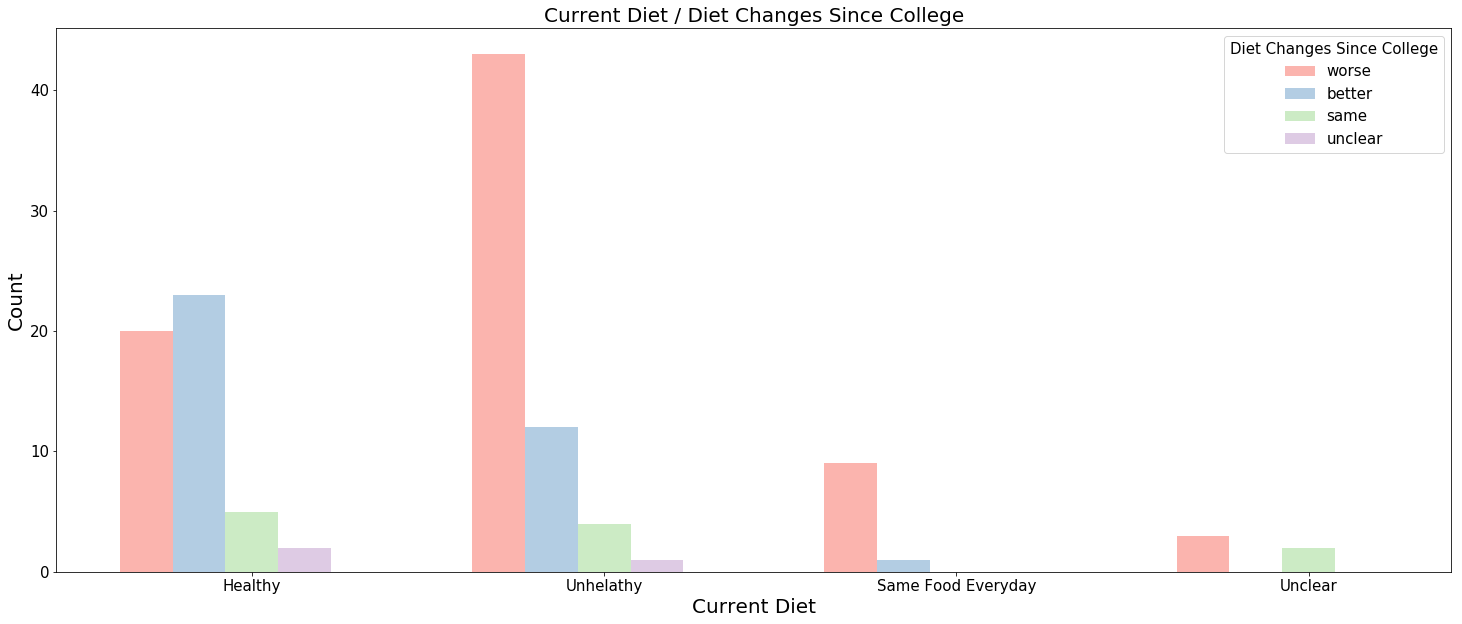

In [309]:
grouped_barchart(x_attribute='diet_current_coded', x_labels=['Healthy' ,'Unhelathy' ,'Same Food Everyday' ,'Unclear'],
                 y_attribute='eating_changes_coded', legend=['worse' ,'better' ,'same' ,'unclear'], legend_title='Diet Changes Since College',
                 plot_title='Current Diet / Diet Changes Since College', x_label='Current Diet')

The above plot shows that 'Unhealthy' people answered 'Worse' when asked about their diet change and 'Healthy' answered 'Better'. Morever, people who said they eat the same food everyday think that it's a worse diet since they don't have varieties.

- ** Students who eat out more frequently are more likely to ingore the nutritional facts of what they eat. Since eating out in geenral means less control over what nutritions you get.**

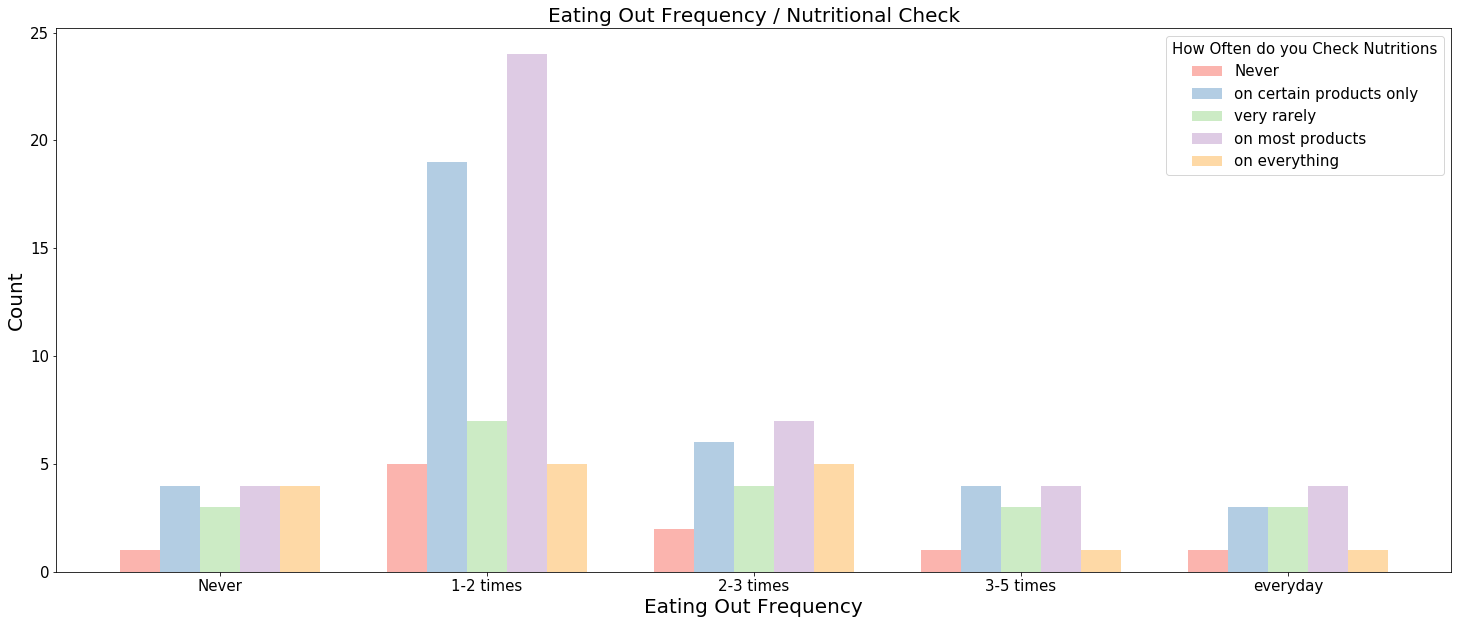

In [313]:
grouped_barchart(x_attribute='eating_out', x_labels=['Never', '1-2 times', '2-3 times', '3-5 times', 'everyday'],
                 y_attribute='nutritional_check', legend=['Never', 'on certain products only', 'very rarely', 'on most products', 'on everything'],
                 legend_title='How Often do you Check Nutritions', plot_title='Eating Out Frequency / Nutritional Check', x_label='Eating Out Frequency')

What the above plot tells us is that students are usually in the middle regarding this issue as they check nutritions on some of the products and only very few students on one of the extremes, either never checking or always checking.

- **Trying to look for a relation between students' weight and their fav cuisines**

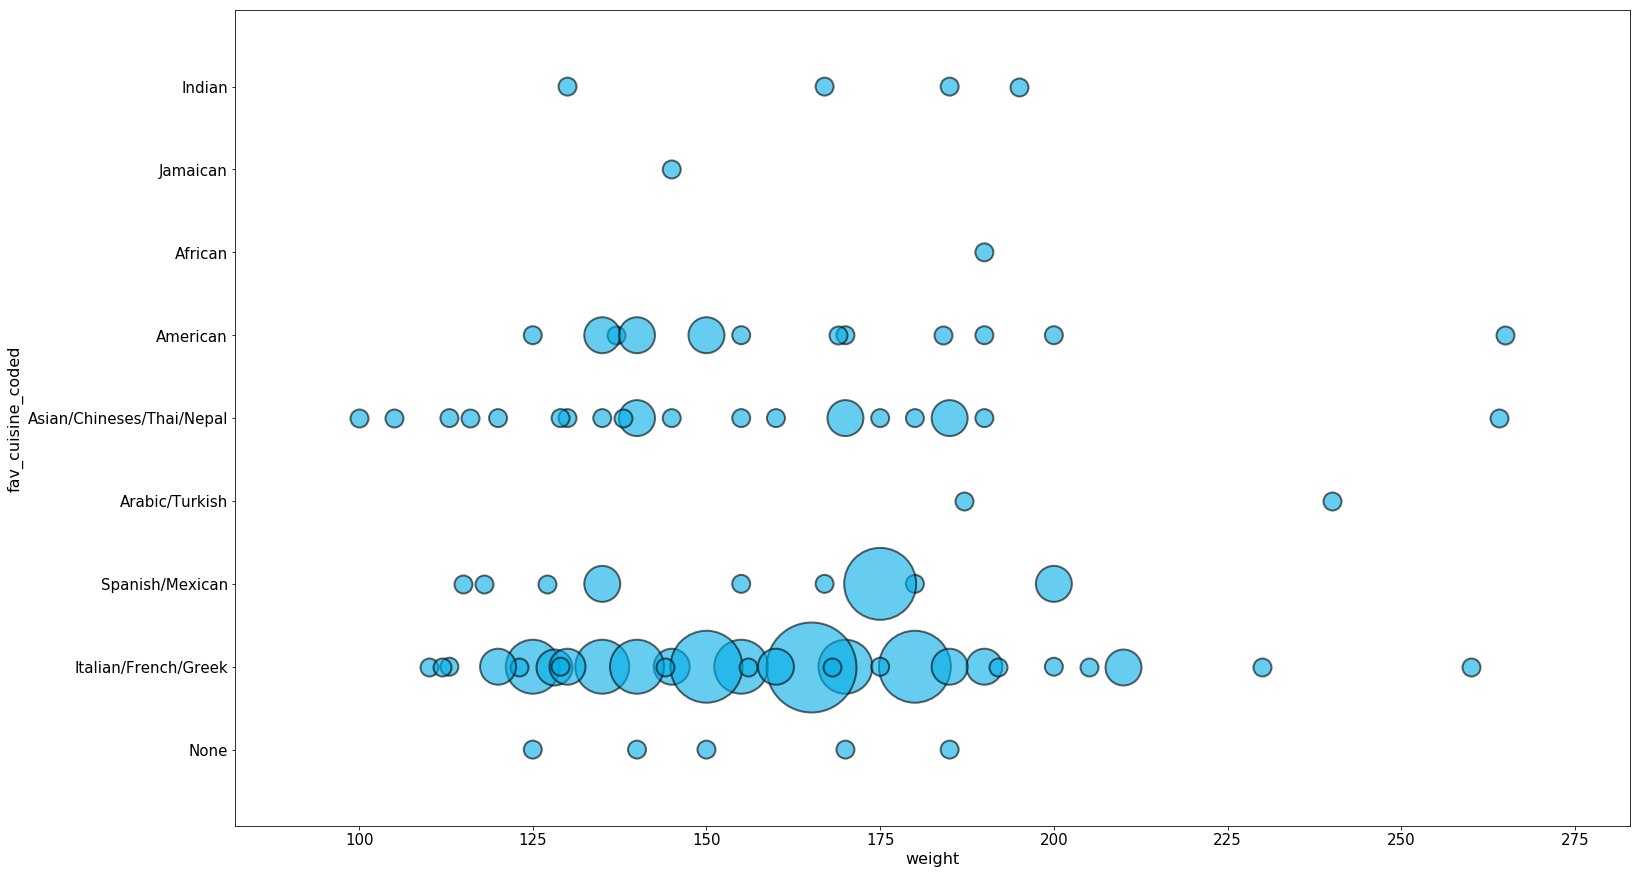

In [391]:
bubble_chart(x_attribute='weight', x_ticks=[], y_attribute='fav_cuisine_coded',
             y_ticks=["None", "Italian/French/Greek", "Spanish/Mexican", "Arabic/Turkish", "Asian/Chineses/Thai/Nepal", "American", "African",
                      "Jamaican", "Indian"], size=0.9)

Most students favor the Italian cuisine (as expected) because pizza and pasta are what comes to mind as italian food and from the wordclouds above, we saw that pizza and pasta were the most common choices as childhood favorite food. After seeing the above results and that most of the weights are in the range 110-200. We decided to plot a boxplt of the weight divided by Gender.

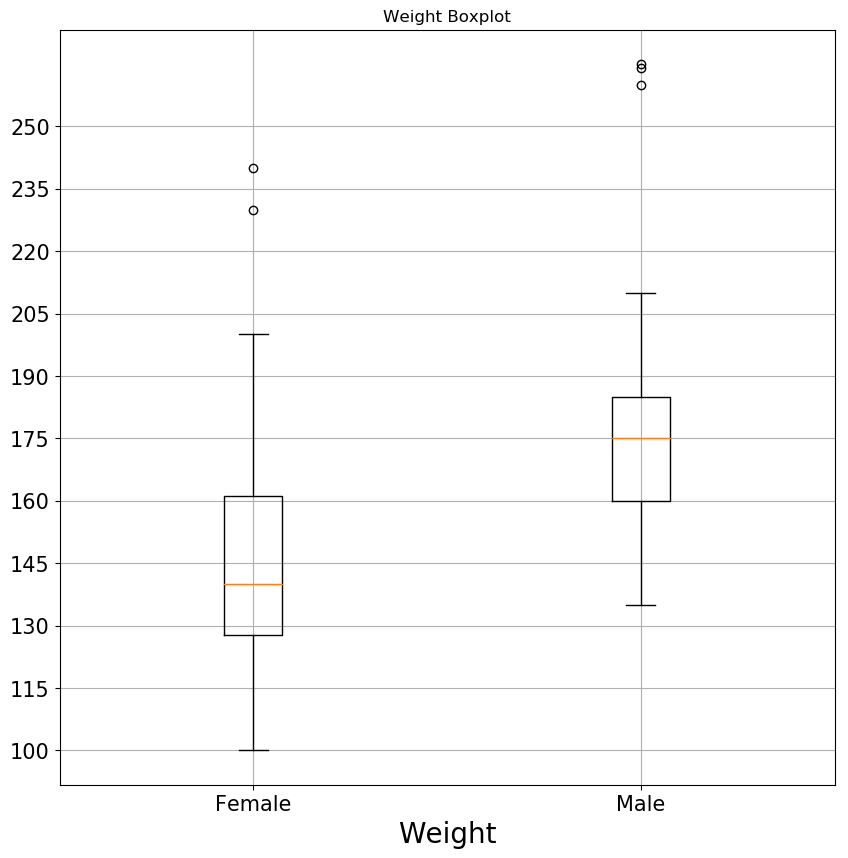

In [334]:
boxplot('weight')

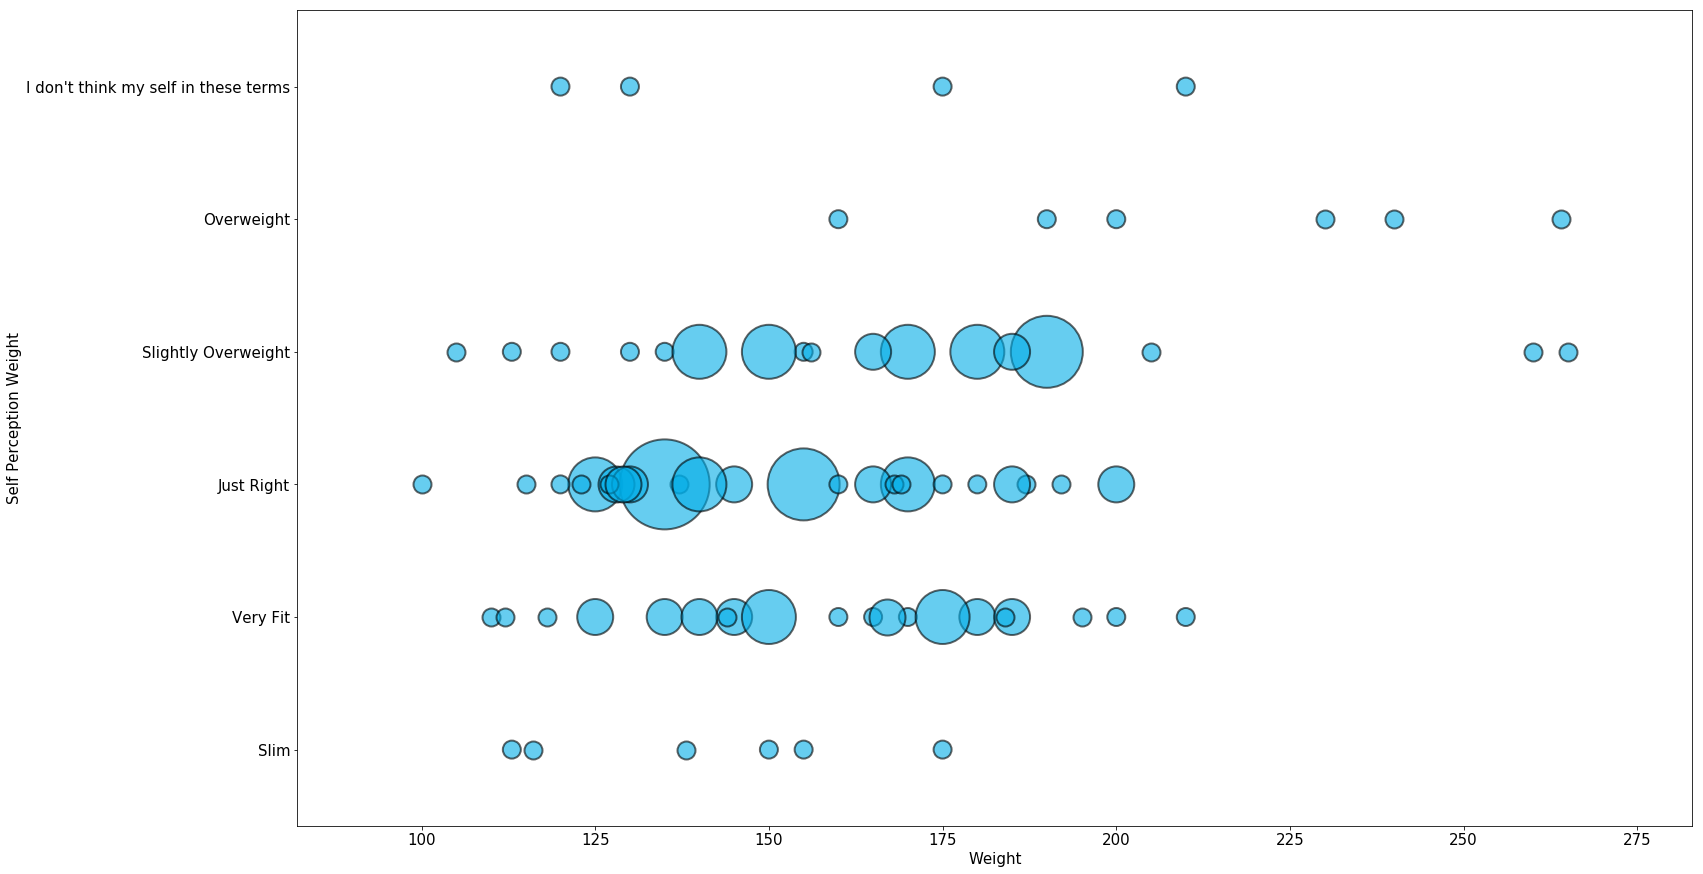

In [399]:
bubble_chart(x_attribute='weight', x_ticks=[], y_attribute='self_perception_weight',
             y_ticks=["", "Slim", "Very Fit", "Just Right", "Slightly Overweight", "Overweight", "I don't think my self in these terms"], size=0.9,
            y_label = 'Self Perception Weight')

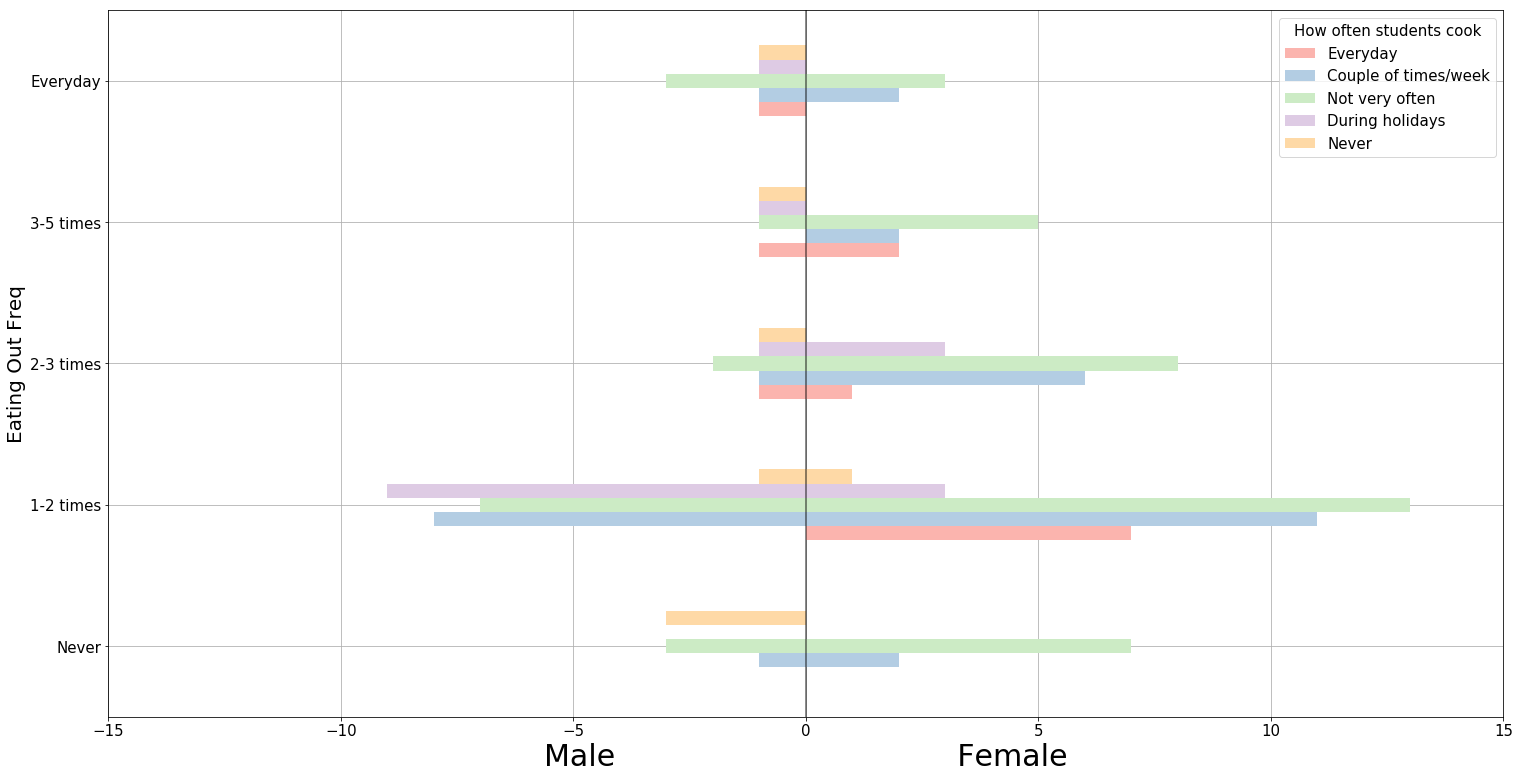

In [378]:
horizontal_barchart(y_attribute='eating_out', y_ticks=['Never', '1-2 times', '2-3 times', '3-5 times', 'Everyday'],
                    x_attribute='cook', legend=['Everyday', 'Couple of times/week', 'Not very often', 'During holidays', 'Never'],
                    legend_title='How often students cook', y_label='Eating Out Freq')

Females: most of them don't cook very often (the green bars are the highest) regardless the freq of eating out.

Males: Their responses were somehow equally distributed on the answers

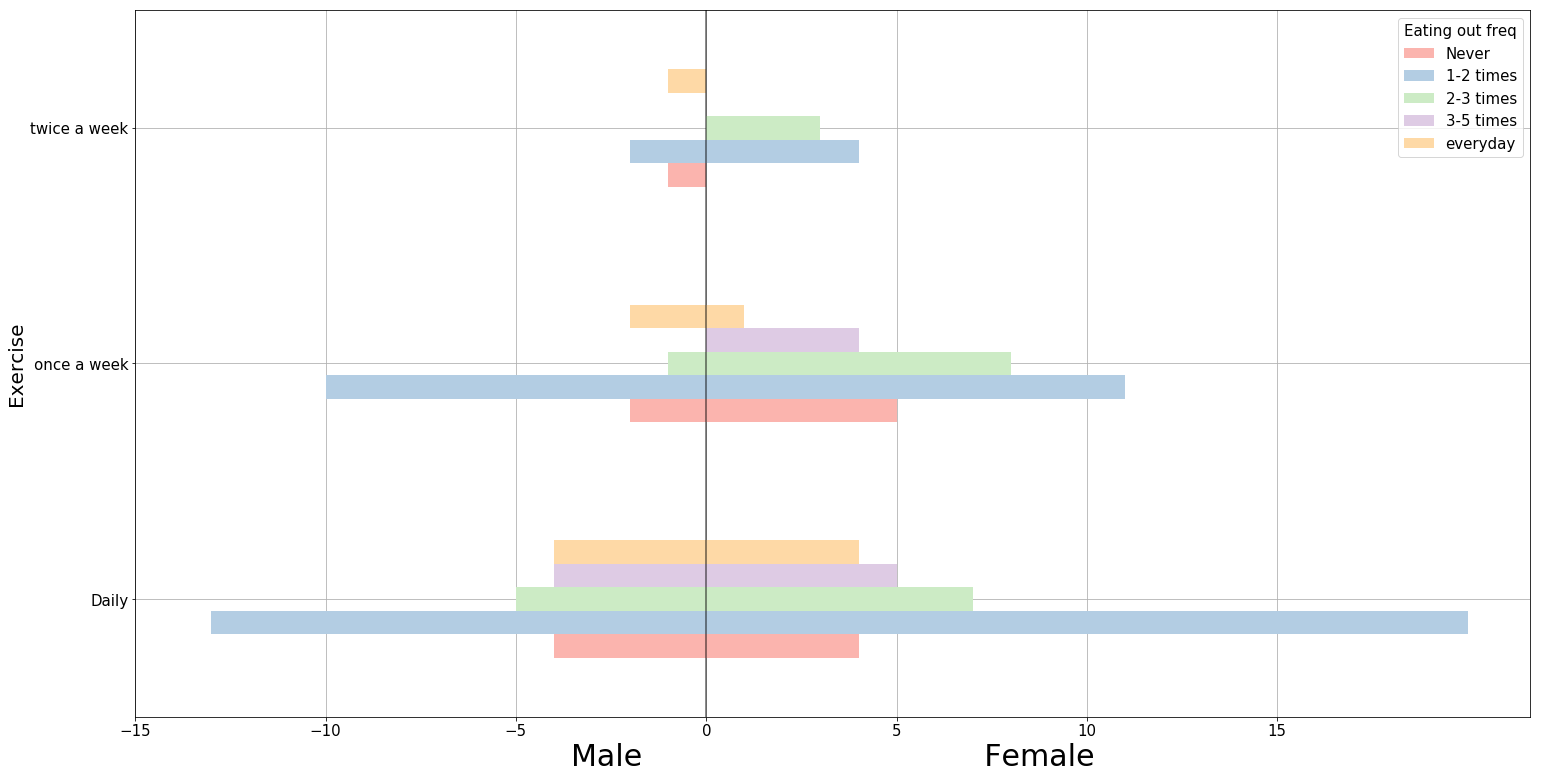

In [382]:
horizontal_barchart('exercise', ['Daily', 'once a week', 'twice a week'], 
                    'eating_out', legend = ['Never', '1-2 times', '2-3 times', '3-5 times', 'everyday'], 
                    legend_title='Eating out freq', y_label='Exercise')

## PCA:

For the PCA computations we wanted features that are numeric so we compiled the below list of features.

In [400]:
column_names = ['GPA',
 'Gender',
 'breakfast',
 'calories_chicken',
 'calories_scone',
 'coffee',
 'cook',
 'comfort_food_reasons_coded',
 'cuisine',
 'diet_current_coded',
 'drink',
 'eating_changes_coded',
 'eating_changes_coded1',
 'eating_out',
 'employment',
 'ethnic_food',
 'exercise',
 'father_education',
 'fav_cuisine_coded',
 'fav_food',
 'fries',
 'fruit_day',
 'grade_level',
 'greek_food',
 'healthy_feeling',
 'ideal_diet_coded',
 'income',
 'indian_food',
 'italian_food',
 'life_rewarding',
 'marital_status',
 'mother_education',
 'nutritional_check',
 'on_off_campus',
 'parents_cook',
 'pay_meal_out',
 'persian_food',
 'self_perception_weight',
 'soup',
 'sports',
 'thai_food',
 'tortilla_calories',
 'turkey_calories',
 'veggies_day',
 'waffle_calories',
 'weight']

In [401]:
clustering_data = pd.DataFrame(data.loc[:, column_names])
pca =  PCA(n_components=2)
fit = pca.fit(clustering_data).transform(clustering_data)
matrix = fit.transpose()

In [402]:
colors = sns.color_palette(n_colors=15)
categorical_columns = [col for col in clustering_data.columns if len(clustering_data[col].unique()) < 5]

@interact(n_clusters=(1,10), group_by=categorical_columns)
def draw_plot(n_clusters, group_by):
    plt.clf()
    plt.rcParams['figure.figsize'] = (18, 15)
    instance = KMeans(n_clusters=n_clusters, random_state = 102)
    clusters_assignment = instance.fit_predict(clustering_data)
        
    plt.subplot(221)
    plt.scatter(matrix[0], matrix[1], s=50, c=[colors[i] for i in clusters_assignment])
    plt.title("K-means Clusters", fontsize=20)

    plt.subplot(222)
    column_unique_values = clustering_data[group_by].unique()
    plt.scatter(matrix[0], matrix[1], s=50, c=[colors[ind] for ind, val in enumerate(column_unique_values, 1)])
    plt.title("Clusters By '%s' Column" % group_by, fontsize=20)
    plt.show()

A Jupyter Widget

We applied PCA to reduce the dimensions to 2 and the ran our K-Means clustering algorithm. As seen above, there were some pretty good defined clusters in our data. However, the plot on the right is coloring the points by the chosen f